# TP3 - Exercício 2
## Grupo 1

*   Diogo Coelho da Silva A100092
*   Pedro Miguel Ramôa Oliveira A97686

**Problema proposto:**
Relativo ao programa do problema anterior,

 1. Construa um “Control Flow Automaton (CFA)” que determina este programa. Identifique os locais e as transições/ramos.  Numa abordagem orientada às pré-condições  identifique os transformadores de predicados associados aos vários locais e os “switches” associados aos vários ramos. 
 2. Construa em `z3` o sistema de equações que representa o comportamento deste sistema dinâmico sob o ponto de vista da prova de segurança e verifique a segurança do programa através da resolução (total ou parcial) deste sistema.
    > sugere-se (não é obrigatório mas é valorizado !), na alínea (a), uma representação do CFA através de  um grafo orientado  implementado  em `networkx`  e a sua compilação para o sistema de equações.


**Proposta Resolução**

O problema apresentado tem como objetivo a construção de um Control Flow Automaton (CFA) para representar o fluxo de controlo de um programa, associado ao algoritmo de Euclides descrito no problema anterior. 

Na nossa solução, o CFA é utilizado como uma abstração formal do programa, destacando os estados do mesmo (locais) e as transições entre estes estados, baseando-se nas condições e transformações das variáveis.

A construção do CFA foi implementada utilizando a biblioteca networkx para criar um grafo orientado. Os estados do programa foram representados por nós, enquanto as transições entre eles foram modeladas como arestas do grafo, cada uma acompanhada de uma etiqueta representando a condição associada à transição.

Após a construção do CFA, o programa foi modelado simbolicamente utilizando a biblioteca z3.
Com o sistema de equações definido, utilizou-se o solver do Z3 para verificar se o programa é seguro. Ao resolver o sistema, foi determinado que o programa satisfaz todas as condições de segurança, sendo classificado como "Seguro". Caso contrário, o solver teria identificado um contra-exemplo, evidenciando uma execução que violaria as condições de segurança.

#### 1. Importar as bibliotecas importantes

In [106]:
import networkx as nx
from z3 import *

- `networkx`: Responsável pelo desenho do grafo
- `pysmt.typing`: Importa tipos específicos usados para criar variáveis simbólicas

#### 2. Criação e desenho do CFA

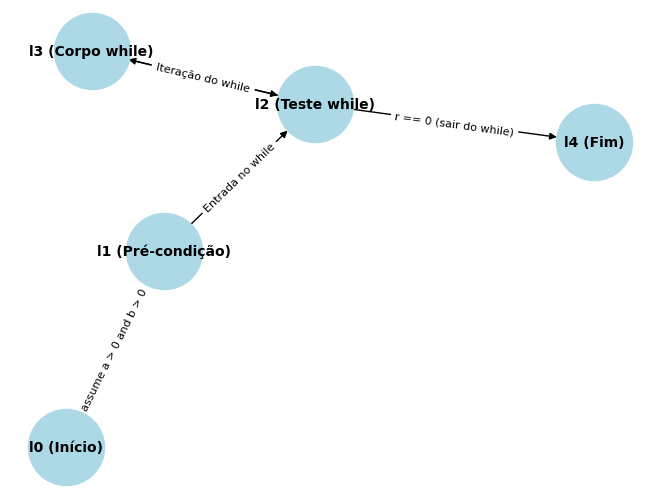

In [107]:
def createCfa():
    G = nx.DiGraph()

    locais = {
        "l0 (Início)": "True",
        "l1 (Pré-condição)": "a > 0 and b > 0",
        "l2 (Teste while)": "r != 0",
        "l3 (Corpo while)": "True",
        "l4 (Fim)": "r == 0"
    }
    
    transitions = [
        ("l0 (Início)", "l1 (Pré-condição)", "assume a > 0 and b > 0"),
        ("l1 (Pré-condição)", "l2 (Teste while)", "Entrada no while"),
        ("l2 (Teste while)", "l3 (Corpo while)", "r != 0 (continuar)"),
        ("l3 (Corpo while)", "l2 (Teste while)", "Iteração do while"),
        ("l2 (Teste while)", "l4 (Fim)", "r == 0 (sair do while)")
    ]

    G.add_nodes_from(locais.keys())
    G.add_edges_from((src, dst, {"label": label}) for src, dst, label in transitions)

    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=3000, font_size=10, font_weight="bold")
    edge_labels = nx.get_edge_attributes(G, "label")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    return G
createCfa()

Cria um grafo orientado CFA, que modela o fluxo de controlo do programa. Cada local do CFA representa um estado ou um ponto no programa.

- l0 (Início): Estado inicial, onde nenhuma condição é aplicada ainda (True).
- l1 (Pré-condição): Verifica se os valores iniciais $a > 0$ e $b > 0$ são válidos.
- l2 (Teste while): Representa o início do laço while, onde a condição $r != 0$ é avaliada.
- l3 (Corpo while): Dentro do corpo do laço while.
- l4 (Fim): Estado final, quando $r == 0$.

Define também as transições:

- De l0 (Início) para l1 (Pré-condição): Transição ocorre assumindo que $a > 0$ e $b > 0$.
- De l2 (Teste while) para l3 (Corpo while): Condição $r != 0$ leva ao node do laço.
- De l2 (Teste while) para l4 (Fim): Quando $r == 0$, o programa termina.


#### 3. Verificar programa e representação do comportamento do mesmo

Utilizamos o Z3 Solver para modelar o programa e verificar se ele é seguro.

O programa define as variáveis do programa:
- a e b: Os dois valores de entrada do programa.
- r: Resto atual (estado anterior do laço).
- r_: Resto após uma iteração do laço.
- q: Quociente calculado em cada iteração.

De seguida define a pré-condição:
Verifica que os valores de entrada $a$ e $b$ são estritamente positivos ($a > 0$ e $b > 0$ ).

Modela a transformação do laço:

Define como as variáveis mudam em cada iteração do laço:
- $r´ = r - q * b $ Representa a atualização do resto.
Garante que $r' ≥0$, ou seja, o novo resto deve ser válido.
Garante que $q≥0$, pois o quociente não pode ser negativo.

Define as condições de segurança:
- Garante que as variáveis $r$ e $r\_$ permanecem não negativas durante a execução.

Define a pós-condição:
- Garante que o programa termina corretamente quando $r == 0$.

In [108]:
def sistemaPrograma():
    a, b = Ints("a b") 
    r, r_, q = Ints("r r_ q") 

    # Pre-condição
    preCondition = And(a > 0, b > 0)

    #Variaveis do loop
    loop_transform = And(
        r_ == r - q * b,
        r_ >= 0,
        q >= 0  
    )
    #Condições de segurança pre-definidas
    safety_conditions = And(r >= 0, r_ >= 0)
    # Pos-Condição:
    postCondition = r_ == 0
    solver = Solver()

    solver.add(preCondition, loop_transform, Not(safety_conditions), Not(postCondition))

    if solver.check() == sat:
        return "Não Seguro", solver.model()
    else:
        return "Seguro", None

status, contraexemplo = sistemaPrograma()
print(f"Estado: {status}")
if contraexemplo:
    print(f"Contra-Exemplo: {contraexemplo}")


Estado: Seguro
